# NOTE:
#### - This code uses OHE for weekly datetime
#### - `DataLoader` function is removed from here as we imported already optimised power demand csv directly

In [1]:
import numpy as np
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import os
import copy
import matplotlib.dates as mdates
from sklearn.preprocessing import OneHotEncoder
from pathlib import Path

# Path

In [2]:
demand_df_path = r"C:\Users\anike\OneDrive\Desktop\IITG project\IITG_electricity\New_Model\Data_Imputation_new_model\Code\New_model_with_class\Demand_data_with_class_2022_2023.csv"

# Classes

### Utilities

In [3]:
class Utilities:

    def __init__(self, T_th=20):
        self.T_th = T_th
        self.encoder = None     # means this class is suppose to have an encoder. It is an instance variable

    def build_features(self, df, temp_col="Temperature", power_col="Power"):
        df_feat = df.copy()
        df_feat.index = pd.to_datetime(df_feat.index)
        df_feat = df_feat.sort_index()

        # Hour-of-week
        df_feat["hour"] = df_feat.index.hour
        df_feat["dayofweek"] = df_feat.index.dayofweek
        df_feat["hour_of_week"] = df_feat["dayofweek"] * 24 + df_feat["hour"]

        T = df_feat[temp_col]
        df_feat["sT"] = np.where(T > self.T_th, T - self.T_th, 0.0)

        # One-hot encode hour_of_week
        self.encoder = OneHotEncoder(
            categories=[np.arange(168)],
            sparse_output=False,        
            handle_unknown="ignore"
        )
        hour_ohe = self.encoder.fit_transform(df_feat[["hour_of_week"]])
        hour_cols = [f"h_{i}" for i in range(168)]

        hour_ohe_df = pd.DataFrame(hour_ohe, index=df_feat.index, columns=hour_cols)

        X = pd.concat([hour_ohe_df, df_feat[["sT"]]], axis="columns")

        return df_feat, X

    def train_imputation_model(self, df_feat, X, power_col="Power",
                               test_size=0.10, random_state=42,
                               fit_intercept=True):
       
        mask_known = df_feat[power_col].notna()

        X_known = X.loc[mask_known].values
        y_known = df_feat.loc[mask_known, power_col].values


        # 90% / 10% split
        X_train, X_test, y_train, y_test = train_test_split(
            X_known,
            y_known,
            test_size=test_size,
            random_state=random_state
        )

        model = LinearRegression(fit_intercept=fit_intercept)
        model.fit(X_train, y_train)

        y_test_pred = model.predict(X_test)
        r2_test = r2_score(y_test, y_test_pred)
        print("R² score:", r2_test)

       
        return model, r2_test

    def impute_missing_power(self, df_feat, X, model, power_col="Power"):
        df_imputed = df_feat.copy()
        p_pred = model.predict(X.values)
        df_imputed["PredictedPower"] = p_pred

        missing_power = df_imputed.Power.isna()
        df_imputed.loc[missing_power, power_col] = df_imputed.loc[missing_power, "PredictedPower"]

        print("Remaining NaNs in Power after imputation:",
              df_imputed[power_col].isna().sum())

        return df_imputed

In [4]:
utilities = Utilities(T_th=20)

In [5]:
demand_df = pd.read_csv(demand_df_path, parse_dates= ["Unnamed: 0"], index_col=0)
demand_df.index = pd.to_datetime(demand_df.index)
demand_df

,Power,Temperature,Class
2022-01-01 00:00:00,NaN,13.40,Vacation
2022-01-01 01:00:00,NaN,12.90,Vacation
2022-01-01 02:00:00,NaN,12.50,Vacation
2022-01-01 03:00:00,NaN,12.00,Vacation
2022-01-01 04:00:00,NaN,13.00,Vacation
...,...,...,...
2023-12-31 19:00:00,3.00,16.11,Vacation
2023-12-31 20:00:00,3.30,16.11,Vacation
2023-12-31 21:00:00,3.25,16.11,Vacation
2023-12-31 22:00:00,NaN,16.11,Vacation


In [6]:
# using 2022 data to train the model
demand_df_2022 = demand_df["2022-01-01":"2022-12-31"]
demand_df_2022

,Power,Temperature,Class
2022-01-01 00:00:00,NaN,13.4,Vacation
2022-01-01 01:00:00,NaN,12.9,Vacation
2022-01-01 02:00:00,NaN,12.5,Vacation
2022-01-01 03:00:00,NaN,12.0,Vacation
2022-01-01 04:00:00,NaN,13.0,Vacation
...,...,...,...
2022-12-31 19:00:00,2.7,18.0,Vacation
2022-12-31 20:00:00,NaN,17.0,Vacation
2022-12-31 21:00:00,2.7,15.4,Vacation
2022-12-31 22:00:00,2.5,17.0,Vacation


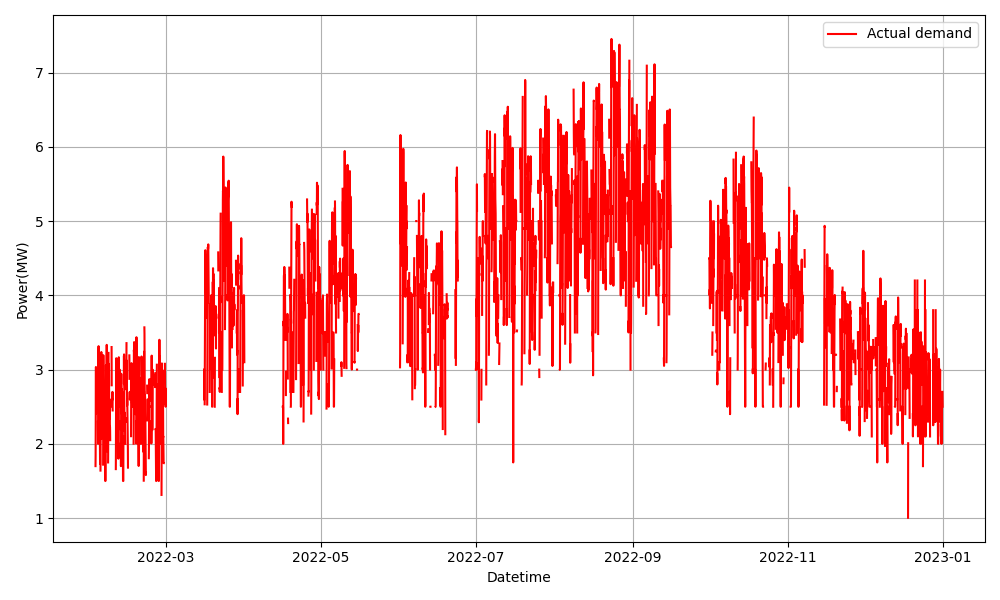

In [7]:
plt.figure(figsize=(10,6))
plt.plot(demand_df_2022.index, demand_df_2022.Power, color="r", label = "Actual demand")
plt.xlabel("Datetime")
plt.ylabel("Power(MW)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Estimating T_th

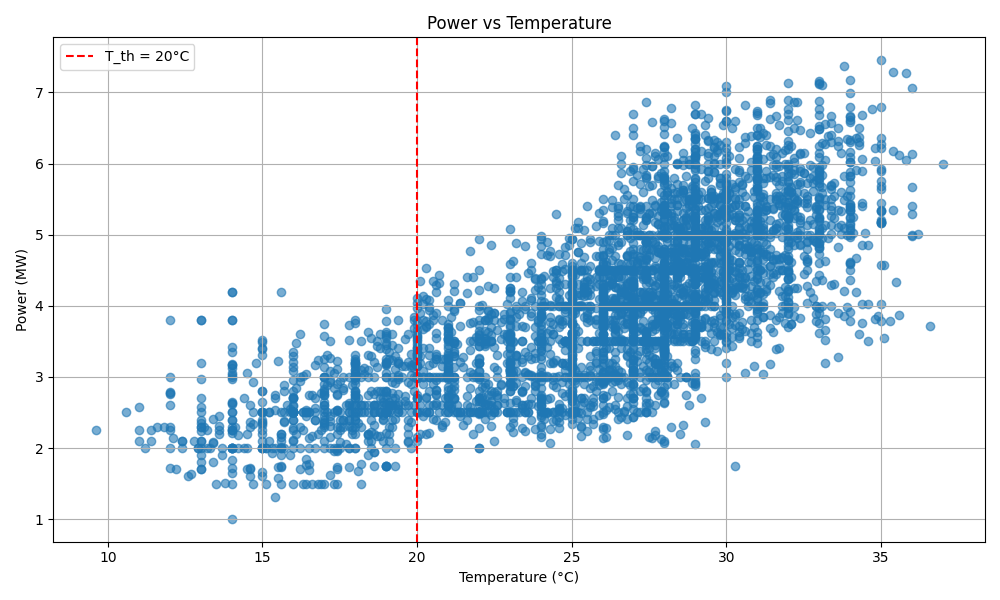

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(demand_df_2022["Temperature"], demand_df_2022["Power"], alpha = 0.6)
plt.axvline(x= 20, color = "red", linestyle = "--", label = "T_th = 20°C")
plt.xlabel('Temperature (°C)')
plt.ylabel('Power (MW)')
plt.title('Power vs Temperature')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# One hot encoding + Training + Imputation

### → OHE

In [9]:
df = demand_df_2022.copy()
df_feat, X = utilities.build_features(df, temp_col="Temperature", power_col="Power")
df_feat.head()

,Power,Temperature,Class,hour,dayofweek,hour_of_week,sT
2022-01-01 00:00:00,NaN,13.4,Vacation,0,5,120,0.0
2022-01-01 01:00:00,NaN,12.9,Vacation,1,5,121,0.0
2022-01-01 02:00:00,NaN,12.5,Vacation,2,5,122,0.0
2022-01-01 03:00:00,NaN,12.0,Vacation,3,5,123,0.0
2022-01-01 04:00:00,NaN,13.0,Vacation,4,5,124,0.0


In [10]:
df_feat.isna().sum()

Power           4728
Temperature        0
Class              0
hour               0
dayofweek          0
hour_of_week       0
sT                 0
dtype: int64

In [11]:
df_feat.notna().sum()

Power           4032
Temperature     8760
Class           8760
hour            8760
dayofweek       8760
hour_of_week    8760
sT              8760
dtype: int64

In [12]:
# input features
X

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,h_159,h_160,h_161,h_162,h_163,h_164,h_165,h_166,h_167,sT
2022-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-31 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### → Training

In [13]:
model_imp, r2_test = utilities.train_imputation_model(
    df_feat,
    X,
    power_col="Power",
    test_size=0.10,
    random_state=42,
    fit_intercept=True
)

R² score: 0.6931827330137077


### → Imputation

In [14]:
df_imputed_2022 = utilities.impute_missing_power(
    df_feat,
    X,
    model_imp,
    power_col="Power"
)

Remaining NaNs in Power after imputation: 0


In [15]:
df_imputed_2022

,Power,Temperature,Class,hour,dayofweek,hour_of_week,sT,PredictedPower
2022-01-01 00:00:00,2.534550,13.4,Vacation,0,5,120,0.0,2.534550
2022-01-01 01:00:00,2.425556,12.9,Vacation,1,5,121,0.0,2.425556
2022-01-01 02:00:00,2.196617,12.5,Vacation,2,5,122,0.0,2.196617
2022-01-01 03:00:00,2.030914,12.0,Vacation,3,5,123,0.0,2.030914
2022-01-01 04:00:00,2.050588,13.0,Vacation,4,5,124,0.0,2.050588
...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,2.700000,18.0,Vacation,19,5,139,0.0,2.738986
2022-12-31 20:00:00,2.832376,17.0,Vacation,20,5,140,0.0,2.832376
2022-12-31 21:00:00,2.700000,15.4,Vacation,21,5,141,0.0,2.907754
2022-12-31 22:00:00,2.500000,17.0,Vacation,22,5,142,0.0,3.012546


## Plotting data

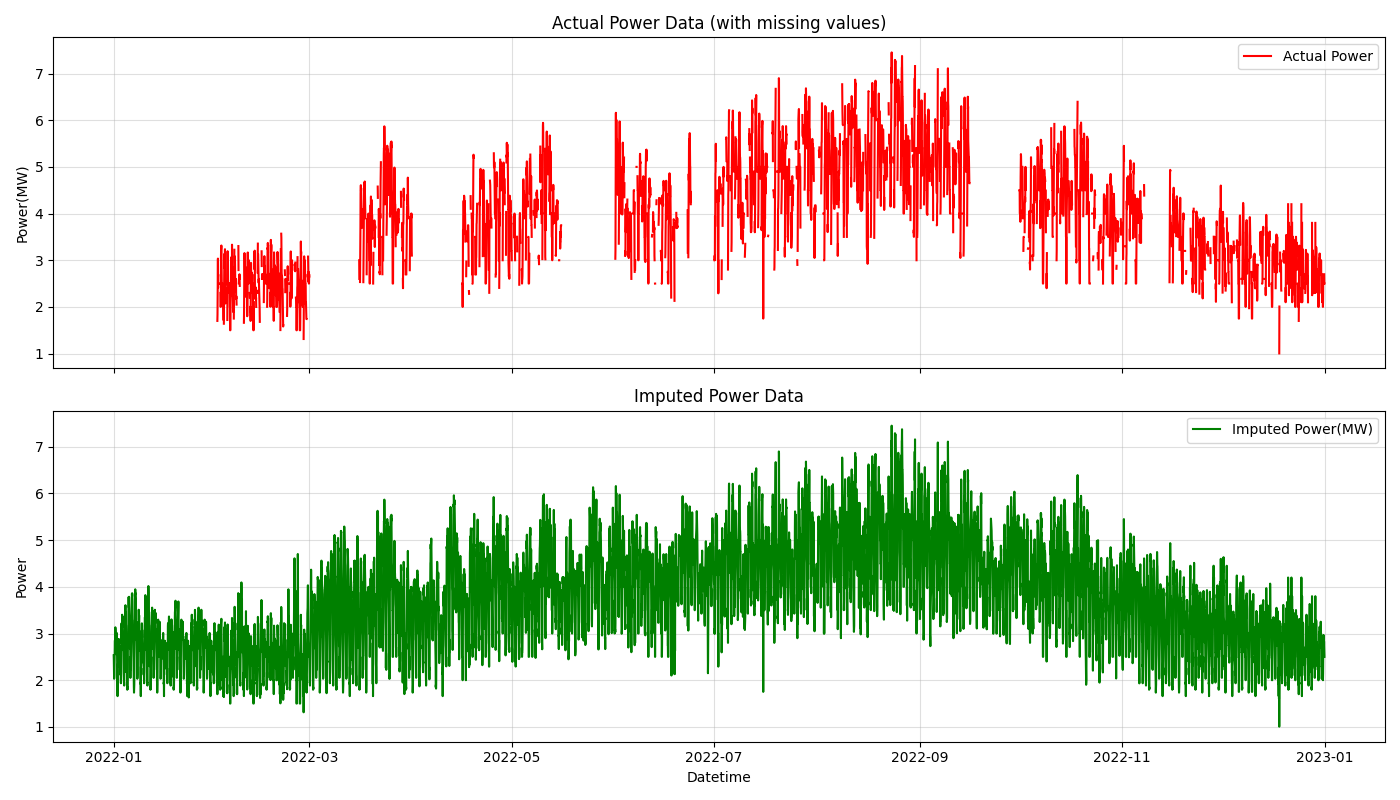

In [ ]:
start_date = "2022-01-01"
end_date   = "2022-12-31"


actual  = demand_df_2022.loc[start_date:end_date]
imputed = df_imputed_2022.loc[start_date:end_date]

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
ax1, ax2 = axes.flatten()

ax1.plot(
    actual.index,
    actual['Power'],
    label="Actual Power",
    color='r'
)
ax1.set_title("Actual Power Data (with missing values)")
ax1.set_ylabel("Power(MW)")
ax1.grid(alpha=0.4)
ax1.legend()

ax2.plot(
    imputed.index,
    imputed['Power'],
    label="Imputed Power(MW)",
    color='g'
)
ax2.set_title("Imputed Power Data")
ax2.set_xlabel("Datetime")
ax2.set_ylabel("Power")
ax2.grid(alpha=0.4)
ax2.legend()


plt.tight_layout()
plt.show()

## Visualizing how good the model is predicting data

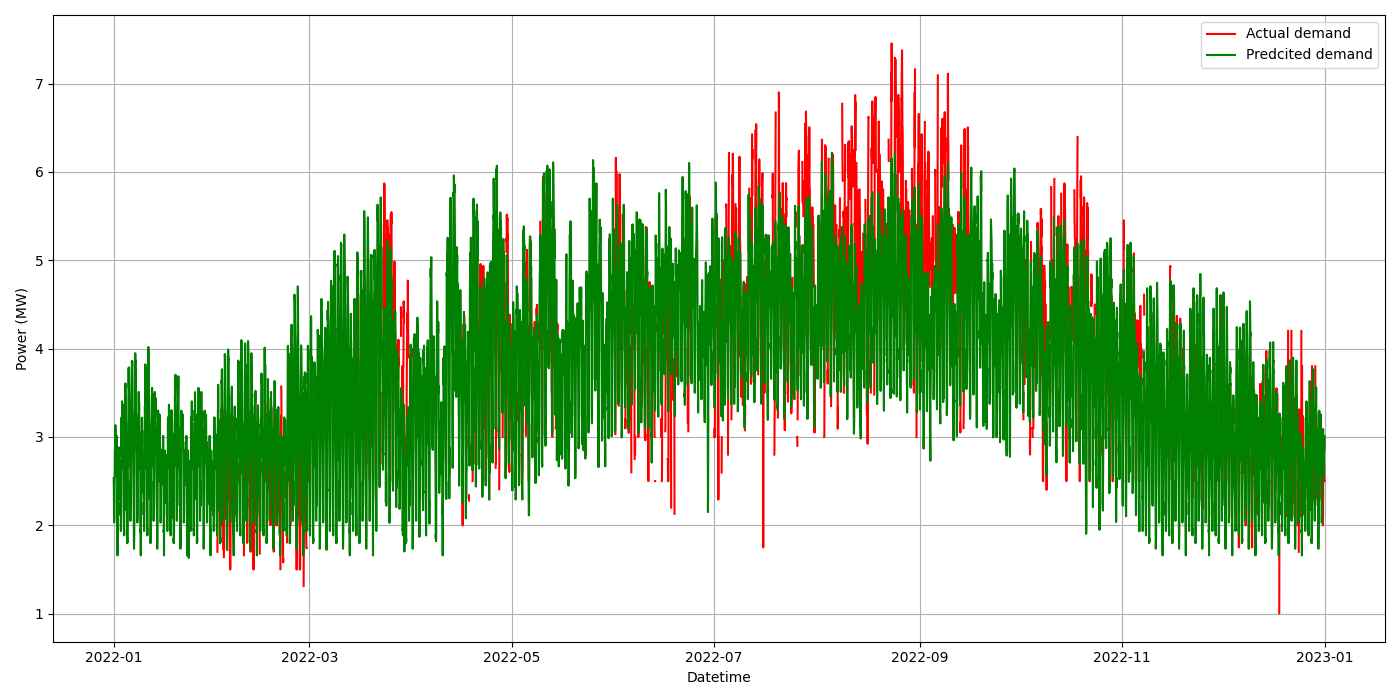

In [17]:
plt.figure(figsize=(14,7))
plt.plot(demand_df_2022.index, demand_df_2022.Power, color = "r", label = "Actual demand")
plt.plot(df_imputed_2022.index, df_imputed_2022.PredictedPower, color = "g", label = "Predcited demand")
plt.grid()
plt.xlabel("Datetime")
plt.ylabel("Power (MW)")
plt.legend()
plt.tight_layout()
plt.show()

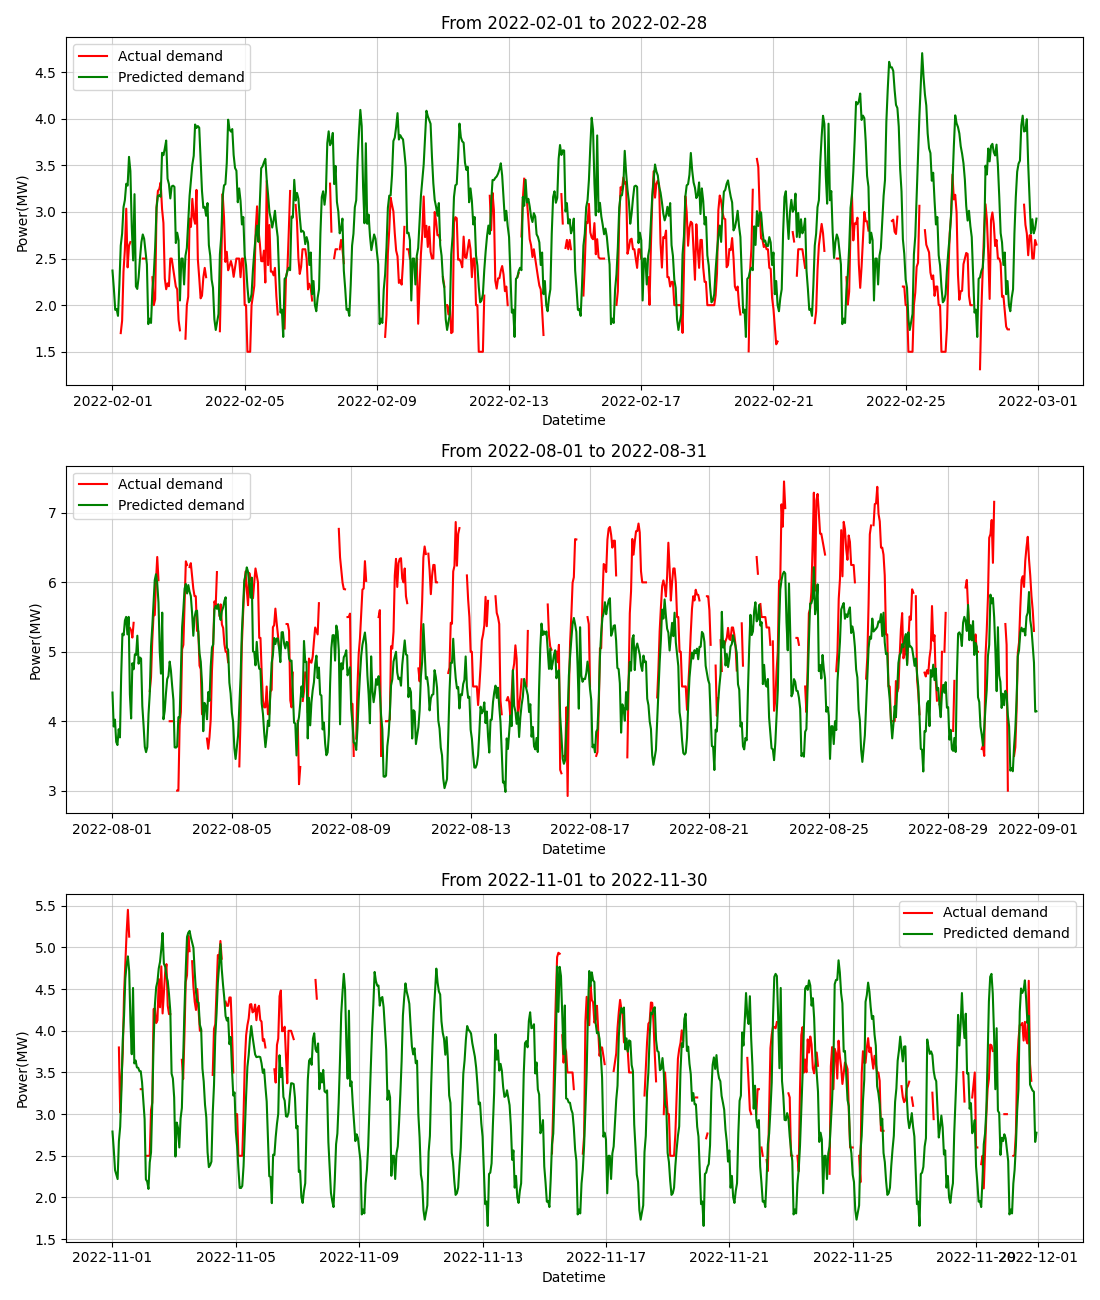

In [18]:
fig, axes = plt.subplots(3,1, figsize=(11, 13), sharex=False)
ax1, ax2, ax3 = axes.flatten()

strt1 = "2022-02-01"
end1 = "2022-02-28"
strt2 = "2022-08-01"
end2 = "2022-08-31"
strt3 = "2022-11-01"
end3 = "2022-11-30"

ax1.plot(
    demand_df_2022.loc[strt1:end1].index,
    demand_df_2022.loc[strt1:end1, "Power"],
    label="Actual demand",
    color='red')

ax1.plot(
    df_imputed_2022.loc[strt1:end1].index,
    df_imputed_2022.loc[strt1:end1, "PredictedPower"],
    label="Predicted demand",
    color='green'
)
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Power(MW)")
ax1.legend()
ax1.set_title(f"From {strt1} to {end1}")
ax1.grid(alpha = 0.6)

ax2.plot(
    demand_df_2022.loc[strt2:end2].index,
    demand_df_2022.loc[strt2:end2, "Power"],
    label="Actual demand",
    color='red')

ax2.plot(
    df_imputed_2022.loc[strt2:end2].index,
    df_imputed_2022.loc[strt2:end2, "PredictedPower"],
    label="Predicted demand",
    color='green'
)
ax2.set_xlabel("Datetime")
ax2.set_ylabel("Power(MW)")
ax2.legend()
ax2.grid(alpha = 0.6)
ax2.set_title(f"From {strt2} to {end2}")


ax3.plot(
    demand_df_2022.loc[strt3:end3].index,
    demand_df_2022.loc[strt3:end3, "Power"],
    label="Actual demand",
    color='red')

ax3.plot(
    df_imputed_2022.loc[strt3:end3].index,
    df_imputed_2022.loc[strt3:end3, "PredictedPower"],
    label="Predicted demand",
    color='green'
)
ax3.set_xlabel("Datetime")
ax3.set_ylabel("Power(MW)")
ax3.legend()
ax3.set_title(f"From {strt3} to {end3}")
ax3.grid(alpha = 0.6)


plt.tight_layout()
plt.show()


In [19]:
print("Actual Peak Power for 2022 data:", demand_df_2022.Power.max())
print("Predicted Peak Power for 2022 data:", df_imputed_2022.PredictedPower.max())
print("Actual Peak Power datetime for 2022 data:", demand_df_2022.Power.idxmax())
print("Predicted Peak Power datetime for 2022 data:", df_imputed_2022.PredictedPower.idxmax())
print("Error in peak prediction = ", abs(demand_df_2022.Power.max()-df_imputed_2022.PredictedPower.max()))


Actual Peak Power for 2022 data: 7.452957400000001
Predicted Peak Power for 2022 data: 6.218037077095855
Actual Peak Power datetime for 2022 data: 2022-08-23 12:00:00
Predicted Peak Power datetime for 2022 data: 2022-08-24 12:00:00
Error in peak prediction =  1.2349203229041459


In [ ]:
from sklearn.metrics import mean_absolute_error

mask_2022 = demand_df_2022["Power"].notna()

y_true_2022 = demand_df_2022.loc[mask_2022, "Power"].values
y_pred_2022 = df_imputed_2022.loc[mask_2022, "PredictedPower"].values

mae_2022 = mean_absolute_error(y_true_2022, y_pred_2022)
print("Model 1 — MAE for 2022:", mae_2022, "MW")


Model 1 — MAE for 2022: 0.5264837866974938 MW


In [21]:
import numpy as np

mask_2022 = (demand_df_2022["Power"].notna()) & (demand_df_2022["Power"] > 0)

y_true_2022 = demand_df_2022.loc[mask_2022, "Power"].values
y_pred_2022 = df_imputed_2022.loc[mask_2022, "PredictedPower"].values

mape_2022 = np.mean(np.abs((y_true_2022 - y_pred_2022) / y_true_2022)) * 100
print("Model 1 — MAPE for 2022:", round(mape_2022, 2), "%")


Model 1 — MAPE for 2022: 14.07 %


# Prediction for 2023

In [22]:
demand_df_2023 = demand_df["2023-01-01":"2023-12-31"].copy()
demand_df_2023

,Power,Temperature,Class
2023-01-01 00:00:00,2.30,13.89,Vacation
2023-01-01 01:00:00,NaN,12.78,Vacation
2023-01-01 02:00:00,NaN,12.64,Vacation
2023-01-01 03:00:00,NaN,12.50,Vacation
2023-01-01 04:00:00,NaN,12.36,Vacation
...,...,...,...
2023-12-31 19:00:00,3.00,16.11,Vacation
2023-12-31 20:00:00,3.30,16.11,Vacation
2023-12-31 21:00:00,3.25,16.11,Vacation
2023-12-31 22:00:00,NaN,16.11,Vacation


In [23]:
df_feat_2023 = demand_df_2023.copy()
df_feat_2023.index = pd.to_datetime(df_feat_2023.index)
df_feat_2023 = df_feat_2023.sort_index()

# hour-of-week
df_feat_2023["hour"] = df_feat_2023.index.hour
df_feat_2023["dayofweek"] = df_feat_2023.index.dayofweek
df_feat_2023["hour_of_week"] = df_feat_2023["dayofweek"] * 24 + df_feat_2023["hour"]

# s(T) 
T = df_feat_2023["Temperature"]
df_feat_2023["sT"] = np.where(T > utilities.T_th, T - utilities.T_th, 0.0)

hour_ohe_2023 = utilities.encoder.transform(df_feat_2023[["hour_of_week"]])
hour_cols = [f"h_{i}" for i in range(168)]
hour_ohe_df_2023 = pd.DataFrame(hour_ohe_2023, index=df_feat_2023.index, columns=hour_cols)

X_2023 = pd.concat([hour_ohe_df_2023, df_feat_2023[["sT"]]], axis="columns")
X_2023

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,h_159,h_160,h_161,h_162,h_163,h_164,h_165,h_166,h_167,sT
2023-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2023-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2023-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2023-12-31 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [24]:
pred_2023 = model_imp.predict(X_2023.values)
demand_df_2023["PredictedPower"] = pred_2023
demand_df_2023

,Power,Temperature,Class,PredictedPower
2023-01-01 00:00:00,2.30,13.89,Vacation,2.730987
2023-01-01 01:00:00,NaN,12.78,Vacation,2.334733
2023-01-01 02:00:00,NaN,12.64,Vacation,1.919992
2023-01-01 03:00:00,NaN,12.50,Vacation,1.952649
2023-01-01 04:00:00,NaN,12.36,Vacation,1.658994
...,...,...,...,...
2023-12-31 19:00:00,3.00,16.11,Vacation,2.509660
2023-12-31 20:00:00,3.30,16.11,Vacation,2.633947
2023-12-31 21:00:00,3.25,16.11,Vacation,2.730405
2023-12-31 22:00:00,NaN,16.11,Vacation,2.672807


## Evaluation for 2023 data

In [ ]:
mask_known_2023 = demand_df_2023["Power"].notna()

y_true_2023 = demand_df_2023.loc[mask_known_2023, "Power"].values
y_pred_2023 = demand_df_2023.loc[mask_known_2023, "PredictedPower"].values

r2_2023 = r2_score(y_true_2023, y_pred_2023)
print("R² score for 2023 prediction:", r2_2023)

R² score for 2023 prediction: 0.6230357989662351


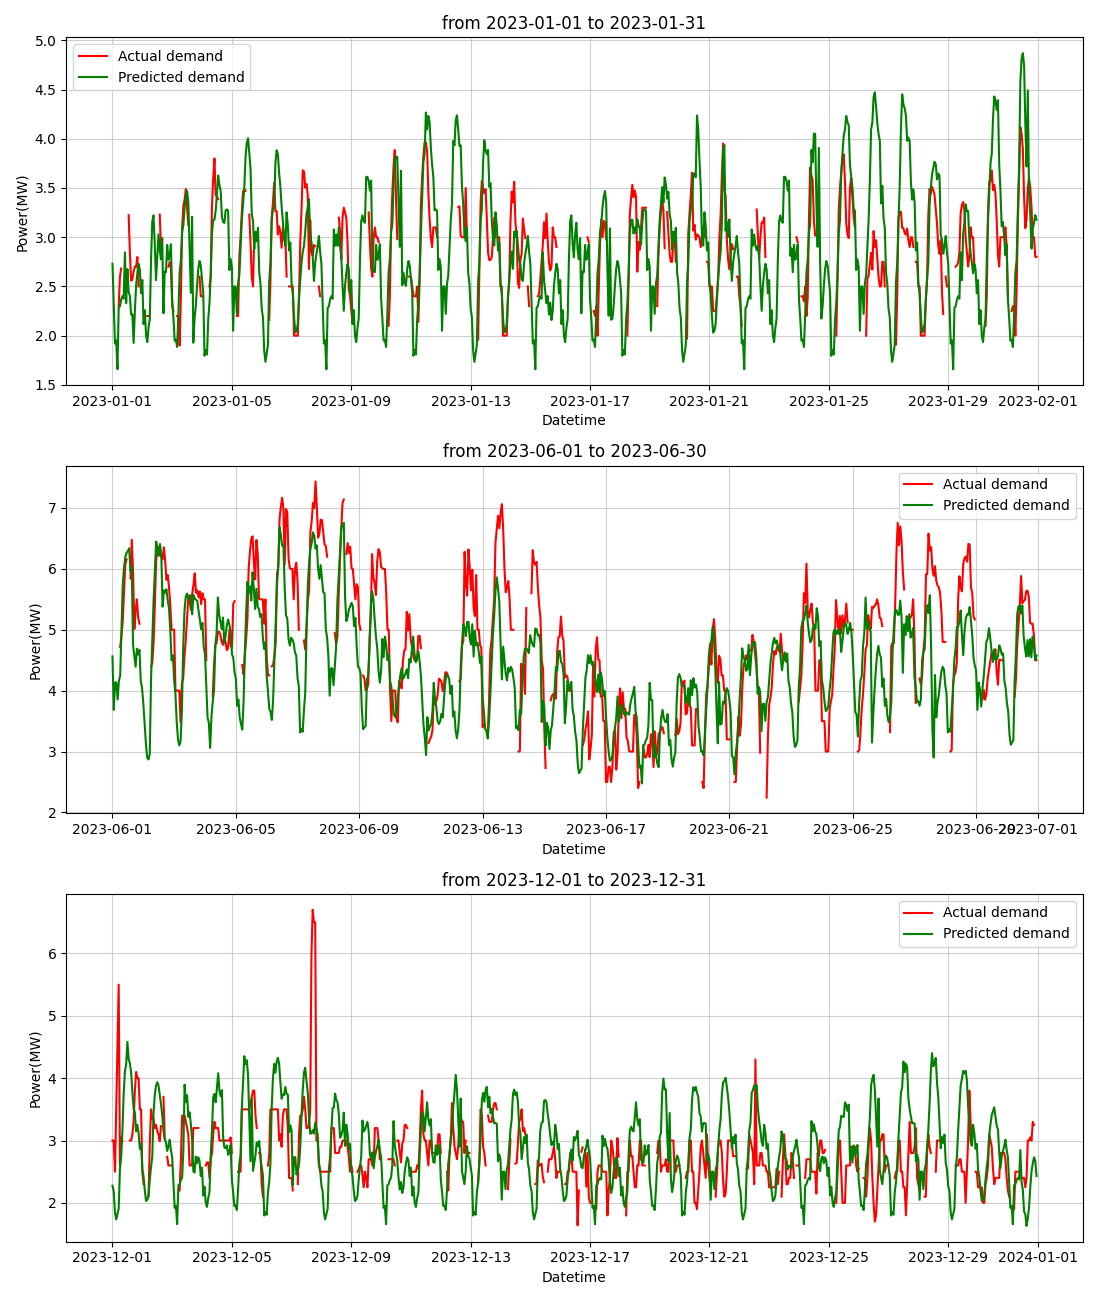

In [26]:
fig, axes = plt.subplots(3,1, figsize=(11, 13), sharex=False)
ax1, ax2, ax3 = axes.flatten()

strt1 = "2023-01-01"
end1 = "2023-01-31"
strt2 = "2023-06-01"
end2 = "2023-06-30"
strt3 = "2023-12-01"
end3 = "2023-12-31"

ax1.plot(
    demand_df_2023.loc[strt1:end1].index,
    demand_df_2023.loc[strt1:end1, "Power"],
    label="Actual demand",
    color='red')

ax1.plot(
    demand_df_2023.loc[strt1:end1].index,
    demand_df_2023.loc[strt1:end1, "PredictedPower"],
    label="Predicted demand",
    color='green'
)
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Power(MW)")
ax1.legend()
ax1.set_title(f"from {strt1} to {end1}")
ax1.grid(alpha = 0.6)

ax2.plot(
    demand_df_2023.loc[strt2:end2].index,
    demand_df_2023.loc[strt2:end2, "Power"],
    label="Actual demand",
    color='red')

ax2.plot(
    demand_df_2023.loc[strt2:end2].index,
    demand_df_2023.loc[strt2:end2, "PredictedPower"],
    label="Predicted demand",
    color='green'
)
ax2.set_xlabel("Datetime")
ax2.set_ylabel("Power(MW)")
ax2.legend()
ax2.grid(alpha = 0.6)
ax2.set_title(f"from {strt2} to {end2}")


ax3.plot(
    demand_df_2023.loc[strt3:end3].index,
    demand_df_2023.loc[strt3:end3, "Power"],
    label="Actual demand",
    color='red')

ax3.plot(
    demand_df_2023.loc[strt3:end3].index,
    demand_df_2023.loc[strt3:end3, "PredictedPower"],
    label="Predicted demand",
    color='green'
)
ax3.set_xlabel("Datetime")
ax3.set_ylabel("Power(MW)")
ax3.legend()
ax3.set_title(f"from {strt3} to {end3}")
ax3.grid(alpha = 0.6)


plt.tight_layout()
plt.show()


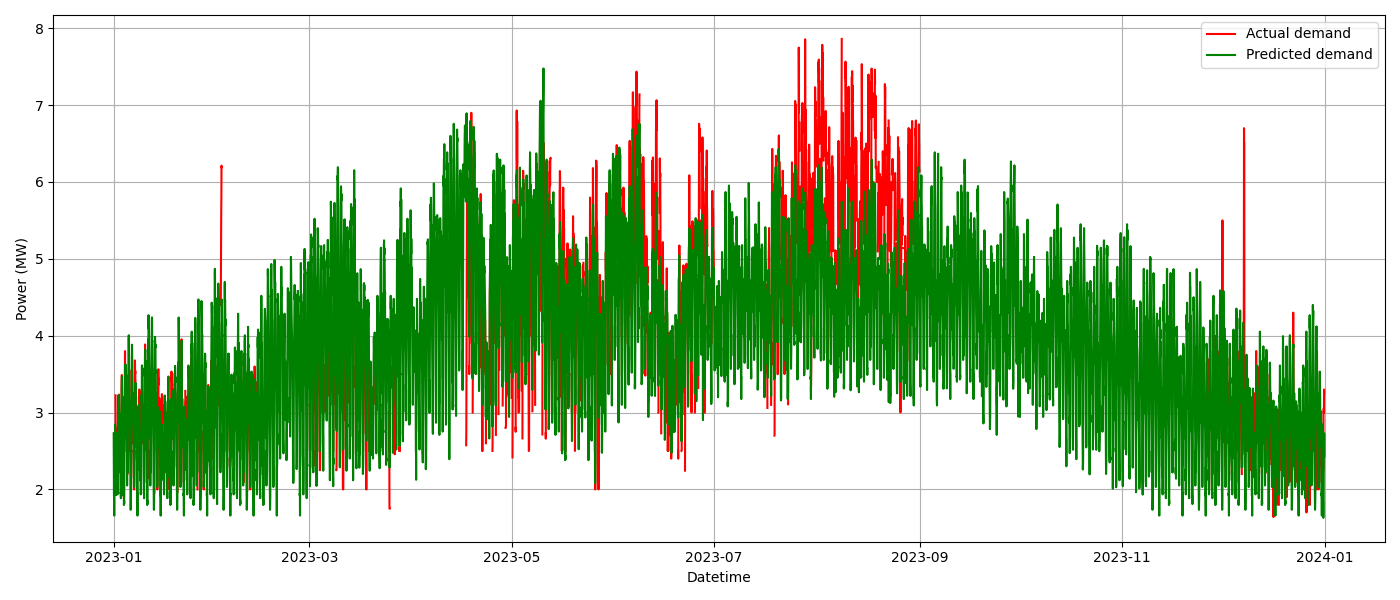

In [27]:
plt.figure(figsize=(14,6))
plt.plot(demand_df_2023.index, demand_df_2023.Power, color = "r", label = "Actual demand")
plt.plot(demand_df_2023.index, demand_df_2023.PredictedPower, color = "g", label = "Predicted demand")
plt.grid()
plt.xlabel("Datetime")
plt.ylabel("Power (MW)")
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
print("Actual Peak Power for 2023 data:", demand_df_2023.Power.max())
print("Predicted Peak Power for 2023 data:", demand_df_2023.PredictedPower.max())
print("Actual Peak Power datetime for 2023 data:", demand_df_2023.Power.idxmax())
print("Predicted Peak Power datetime for 2023 data:", demand_df_2023.PredictedPower.idxmax())
print("Error in peak prediction = ", abs(demand_df_2023.Power.max()-demand_df_2023.PredictedPower.max()))

Actual Peak Power for 2023 data: 7.8610411
Predicted Peak Power for 2023 data: 7.477158500270588
Actual Peak Power datetime for 2023 data: 2023-08-08 11:00:00
Predicted Peak Power datetime for 2023 data: 2023-05-10 13:00:00
Error in peak prediction =  0.38388259972941174


In [ ]:
from sklearn.metrics import mean_absolute_error

mask_2023 = demand_df_2023["Power"].notna()

y_true_2023 = demand_df_2023.loc[mask_2023, "Power"].values
y_pred_2023 = demand_df_2023.loc[mask_2023, "PredictedPower"].values

mae_2023 = mean_absolute_error(y_true_2023, y_pred_2023)
print("Model 1 — MAE for 2023:", mae_2023, "MW")


Model 1 — MAE for 2023: 0.6333184517581757 MW


In [30]:
import numpy as np

mask_2023 = (demand_df_2023["Power"].notna()) & (demand_df_2023["Power"] > 0)

y_true_2023 = demand_df_2023.loc[mask_2023, "Power"].values
y_pred_2023 = demand_df_2023.loc[mask_2023, "PredictedPower"].values

mape_2023 = np.mean(np.abs((y_true_2023 - y_pred_2023) / y_true_2023)) * 100
print("Model 1 — MAPE for 2023:", round(mape_2023, 2), "%")


Model 1 — MAPE for 2023: 15.52 %


In [31]:
demand_df_2022

,Power,Temperature,Class
2022-01-01 00:00:00,NaN,13.4,Vacation
2022-01-01 01:00:00,NaN,12.9,Vacation
2022-01-01 02:00:00,NaN,12.5,Vacation
2022-01-01 03:00:00,NaN,12.0,Vacation
2022-01-01 04:00:00,NaN,13.0,Vacation
...,...,...,...
2022-12-31 19:00:00,2.7,18.0,Vacation
2022-12-31 20:00:00,NaN,17.0,Vacation
2022-12-31 21:00:00,2.7,15.4,Vacation
2022-12-31 22:00:00,2.5,17.0,Vacation
